In [1]:
%tensorflow_version 1.x
import tensorflow as tf
#tf.enable_eager_execution()
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy import optimize
import matplotlib.dates as dates
from ipywidgets import interact, widgets
from scipy.integrate import solve_ivp
plt.style.use('seaborn-poster')
matplotlib.rcParams['figure.figsize'] = (10., 6.)
import copy
import sympy
%matplotlib inline
import scipy as sp
from scipy.integrate import odeint
import datetime as dt
import timeit
import time
import os
from scipy.interpolate import CubicSpline
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
np.set_printoptions(threshold=np.inf)
from prettytable import PrettyTable  
import matplotlib as mpl
import matplotlib.dates as mdates

TensorFlow 1.x selected.


In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/Jiel73654/Qualify-Exam_JieLong/master/Public-Dataset-Daily-Case-Info1.csv",error_bad_lines = False)
data[26:]

,DATE,TOTAL_CASES,NEW_CASES,TOTAL_CONFIRMED,NEW_CONFIRMED,TOTAL_PROBABLE,NEW_PROBABLE,POS_TESTS,NEG_TESTS,TOTAL_TESTS,NEW_TESTS,NEW_DEATHS,TOTAL_DEATHS,NEW_RECOVERED,TOTAL_RECOVERED,NEW_ACTIVE,TOTAL_ACTIVE,NEW_HOSP,TOTAL_HOSP
26,3/30/2020,1834,297.0,NaN,NaN,NaN,NaN,1834.0,21470.0,23304.0,2730.0,6.0,13.0,NaN,109.0,182.0,1712.0,15.0,148.0
27,3/31/2020,2239,405.0,NaN,NaN,NaN,NaN,2239.0,25121.0,27360.0,4056.0,10.0,23.0,12.0,121.0,383.0,2095.0,27.0,175.0
28,4/1/2020,2683,444.0,NaN,NaN,NaN,NaN,2683.0,29769.0,32452.0,5092.0,1.0,24.0,16.0,137.0,427.0,2522.0,25.0,200.0
29,4/2/2020,2845,162.0,NaN,NaN,NaN,NaN,2845.0,31766.0,34611.0,2159.0,8.0,32.0,83.0,220.0,71.0,2593.0,63.0,263.0
30,4/3/2020,3067,222.0,NaN,NaN,NaN,NaN,3067.0,34772.0,37839.0,3228.0,5.0,37.0,28.0,248.0,189.0,2782.0,30.0,293.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,8/7/2020,118782,2432.0,117087.0,2286.0,1695.0,146.0,140166.0,1520171.0,1660337.0,26695.0,20.0,1206.0,1799.0,79357.0,613.0,38219.0,81.0,5190.0
156,8/8/2020,120585,1803.0,118821.0,1734.0,1764.0,69.0,142450.0,1541272.0,1683722.0,23385.0,9.0,1215.0,983.0,80340.0,811.0,39030.0,72.0,5262.0
157,8/9/2020,122712,2127.0,120911.0,2090.0,1801.0,37.0,144931.0,1566388.0,1711319.0,27597.0,8.0,1223.0,657.0,80997.0,1462.0,40492.0,42.0,5304.0
158,8/10/2020,123914,1202.0,122097.0,1186.0,1817.0,16.0,146416.0,1579674.0,1726090.0,14771.0,10.0,1233.0,2173.0,83170.0,-981.0,39511.0,35.0,5339.0


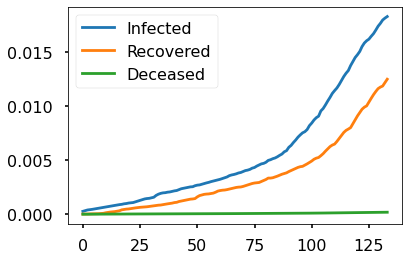

In [3]:
length = 134#time period
ic = data["TOTAL_CASES"]
IC = ic.iloc[26:].to_numpy().reshape(length,1)
dc = data["TOTAL_DEATHS"]
DC = dc.iloc[26:].to_numpy().reshape(length,1)
re = data["TOTAL_RECOVERED"]
RC = re.iloc[26:].to_numpy().reshape(length,1)
N0 = 6.82*1.e6#The total population of tennessee
T = np.arange(0,length).reshape(length,1)
II = IC - RC - DC
SS = N0 - II - RC - DC
RR = DC + RC
plt.plot(T,IC/N0)
plt.plot(T,RC/N0)
plt.plot(T,DC/N0)
plt.legend(("Infected","Recovered","Deceased"))

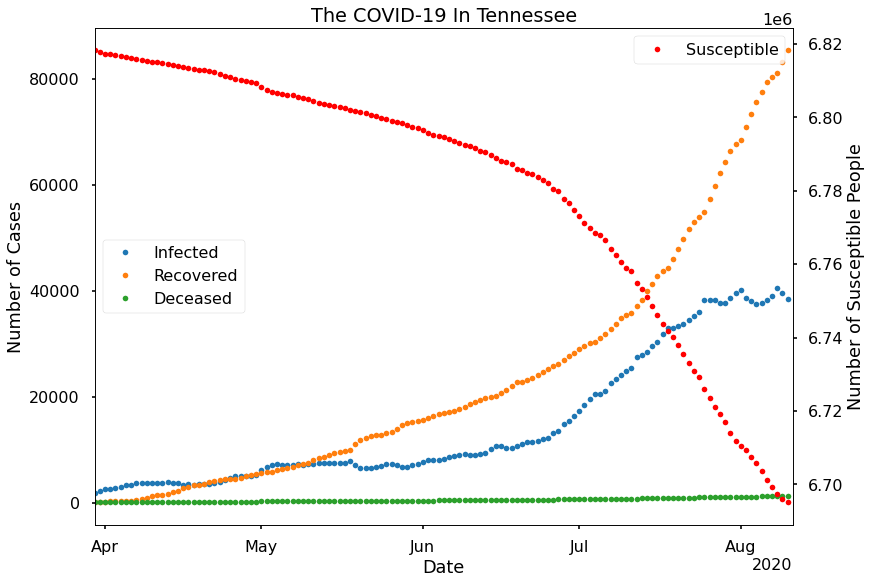

In [4]:
date_begin = dt.datetime(2020,3,30)
date_end = dt.datetime(2020,8,11)
delta = dt.timedelta(days=1)
dates = mpl.dates.drange(date_begin, date_end, delta)
fig, axs = plt.subplots(constrained_layout=True, figsize=(12, 8))
lims = (np.datetime64('2020-03-30'), np.datetime64('2020-08-11'))
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)
axs.plot(dates, II,'.')
axs.plot(dates, RC,'.')
axs.plot(dates, DC,'.')
axs.set_xlabel("Date")
axs.set_ylabel("Number of Cases")
axs.set_xlim(lims)
axs.legend(("Infected","Recovered","Deceased"),loc = "center left")
ax1 = axs.twinx()
ax1.plot(dates,SS,'.',c = 'red')
ax1.legend(["Susceptible"])
ax1.set_ylabel("Number of Susceptible People")
axs.set_title('The COVID-19 In Tennessee')
plt.show()

In [5]:
#SIRD model
np.random.seed(12345)
tf.set_random_seed(12345)
#tf.compat.v1.disable_eager_execution()
class SIRD:
    def __init__(self, I, R, S,D, T,N0, layers):
        self.t = T
        self.I = I
        self.R = R
        self.S = S
        self.D = D
        self.layers = layers
        self.N = N0
        self.lb = T.min()
        self.ub = T.max()
        # Initialize NN
        self.weights1, self.biases1 = self.initialize_NN(self.layers)
        self.weights2, self.biases2 = self.initialize_NN(self.layers)
        self.weights3, self.biases3 = self.initialize_NN(self.layers)
        self.weights4, self.biases4 = self.initialize_NN(self.layers)
        self.weights5, self.biases5 = self.initialize_NN(self.layers)
        #self.weights6, self.biases6 = self.initialize_NN(self.layers)
        #self.weights7, self.biases7 = self.initialize_NN(self.layers)
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.I_tf = tf.placeholder(tf.float32, shape=[None, self.I.shape[1]])
        self.R_tf = tf.placeholder(tf.float32, shape=[None, self.R.shape[1]])
        self.S_tf = tf.placeholder(tf.float32, shape=[None, self.S.shape[1]])
        self.D_tf = tf.placeholder(tf.float32, shape=[None, self.D.shape[1]])
        self.S_pred, self.I_pred, self.R_pred,self.D_pred,self.beta_pred,self.gamma_pred,self.mu_pred,self.E1_pred, self.E2_pred, self.E3_pred, self.E4_pred,self.E5_pred = self.physic(
            self.t_tf)
        self.GE_loss = tf.reduce_mean(tf.square(self.E1_pred)) + tf.reduce_mean(tf.square(self.E2_pred)) +\
                        tf.reduce_mean(tf.square(self.E3_pred)) + tf.reduce_mean(tf.square(self.E4_pred)) + tf.reduce_mean(tf.square(self.E5_pred))
        self.S_loss = 0
        self.I_loss = 0
        self.R_loss = 0
        self.D_loss = 0
        iter = 0
        for i in range(len(T)):
            if T[i]%1 == 0:
                self.S_loss += tf.square(self.S_tf[iter] - self.S_pred[i])
                self.I_loss += tf.square(self.I_tf[iter] - self.I_pred[i])
                self.R_loss += tf.square(self.R_tf[iter] - self.R_pred[i])
                self.D_loss += tf.square(self.D_tf[iter] - self.D_pred[i])
                iter += 1
        self.OB_loss = (self.I_loss + self.R_loss + self.S_loss + self.D_loss)/iter
        self.loss = self.OB_loss + self.GE_loss
        '''
        self.loss = tf.reduce_mean(tf.abs(self.I_tf - self.I_pred)) + tf.reduce_mean(tf.abs(self.R_pred - self.R_tf)) +\
                    tf.reduce_mean(tf.abs(self.S_tf - self.S_pred)) +\
                    tf.reduce_mean(tf.abs(self.E1_pred))+ tf.reduce_mean(tf.abs(self.E2_pred)) +\
                    tf.reduce_mean(tf.abs(self.E3_pred)) + tf.reduce_mean(tf.abs(self.E4_pred)) 
        '''
        
        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        # Optimizers
        '''
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})    
        '''                                                                                          
        init = tf.global_variables_initializer()
        self.sess.run(init)
         
        
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers)
        
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def forward_soft(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.softplus(tf.add(tf.matmul(H, W), b))
        return Y

    def forward_sig(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.sigmoid(tf.add(tf.matmul(H, W), b))
        return Y

    def physic(self, t):
        beta = self.forward_sig(t,self.weights5,self.biases4)
        gamma = self.forward_sig(t,self.weights6,self.biases5)
        mu = self.forward_sig(t,self.weights7,self.biases6)
        S = self.forward_sig(t, self.weights1, self.biases1)
        I = self.forward_sig(t, self.weights2, self.biases2)
        R = self.forward_sig(t, self.weights3, self.biases3)
        D = self.forward_sig(t, self.weights4, self.biases7)
        E1 = tf.gradients(S, t)[0] + beta*S*I
        E2 = tf.gradients(I, t)[0] - beta*S*I + (mu+gamma)*I
        E3 = tf.gradients(R, t)[0] - gamma*I
        E4 = tf.gradients(D, t)[0] - mu*I
        E5 = 1 - (S+I+R+D)
        return S,I,R,D,beta,gamma,mu,E1,E2,E3,E4,E5

    def callback(self, loss):
        print('Loss: %.3e' % (loss))
    def train(self, nIter): 

        tf_dict = {self.t_tf: self.t, self.I_tf: self.I,self.R_tf: self.R,self.S_tf: self.S,self.D_tf: self.D}
                   
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 500 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value,elapsed))
                start_time = time.time()      
    def predict(self, t_star):
        tf_dict = {self.t_tf: t_star}
        S = self.sess.run(self.S_pred, tf_dict)
        I = self.sess.run(self.I_pred, tf_dict)
        R = self.sess.run(self.R_pred, tf_dict)
        D = self.sess.run(self.D_pred, tf_dict)
        beta = self.sess.run(self.beta_pred,tf_dict)
        gamma = self.sess.run(self.gamma_pred,tf_dict)
        mu = self.sess.run(self.mu_pred,tf_dict)
        #gamma = self.sess.run(self.gamma_pred,tf_dict)
        return S,I,R,D,beta,gamma,mu

In [25]:
T = np.arange(0,length - 0.05,0.05)#here I used Nt with 0.1 stepsize
T = T.reshape(len(T),1)
layers = [1,32,32,32,32,1]
model = SIRD(II/N0,RC/N0,SS/N0,DC/N0,T,1,layers)
model.train(100000)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

It: 0, Loss: 2.208e+00, Time: 9.53
It: 500, Loss: 1.475e-04, Time: 23.46
It: 1000, Loss: 3.990e-05, Time: 23.45
It: 1500, Loss: 1.761e-05, Time: 23.61
It: 2000, Loss: 9.505e-06, Time: 23.98
It: 2500, Loss: 5.970e-06, Time: 24.01
It: 3000, Loss: 4.339e-06, Time: 23.85
It: 3500, Loss: 3.481e-06, Time: 23.93
It: 4000, Loss: 2.959e-06, Time: 24.05
It: 4500, Loss: 2.592e-06, Time: 23.92
It: 5000, Loss: 2.303e-06, Time: 23.85
It: 5500, Loss: 2.060e-06, Time: 23.87
It: 6000, Loss: 1.849e-06, Time: 23.89
It: 6500, Loss: 1.660e-06, Time: 24.25
It: 7000, Loss: 1.491e-06, Time: 24.28
It: 7500, Loss: 1.341e-06, Time: 23.83
It: 8000, Loss: 1.211e-06, Time: 23.85
It: 8500, Loss: 1.101e-06, Time: 24.07
It: 9000, Loss: 1.006e-06, Time: 23.88
It: 9500, Loss: 9.207e-07, Time: 23.85
It: 10000, Loss: 8.396e-07, Time: 23.72
It: 10500, Loss: 7.599e-07, Time: 23.77
It: 11000, Loss: 6.780e-07, Time: 23.56
It: 11500, Lo

[9.99731085e-01 2.51026393e-04 1.59824047e-05 1.90615836e-06]
[1.14592997]


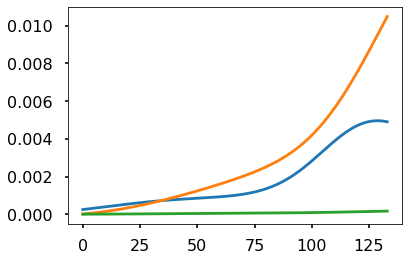

In [20]:
T = np.arange(0,length).reshape(length,1)
s,i,r,d,beta,gamma,mu= model.predict(T)
def sird_model(z,t,beta_value,gamma,mu):
    s = z[0,]
    i = z[1,]
    r = z[2,]
    d = z[3,]
    dsdt = -beta_value*i*s
    didt = beta_value*i*s - (mu+gamma)*i
    drdt = gamma*i
    dddt = mu*i
    dzdt = [dsdt,didt,drdt,dddt]
    dzdt = np.array(dzdt)
    return dzdt
t = np.arange(0,T.shape[0])
# initial condition
z10 = np.array([SS[0,0]/N0,II[0,0]/N0,RC[0,0]/N0,DC[0,0]/N0])
print(z10)
rk1_s = [0.0]*T.shape[0]
rk1_i = [0.0]*T.shape[0]
rk1_r = [0.0]*T.shape[0]
rk1_d = [0.0]*T.shape[0]
rk1_s[0] = z10[0]
rk1_i[0] = z10[1]
rk1_r[0] = z10[2]
rk1_d[0] = z10[3]
# solve ODE
for l in range(1,T.shape[0]):
  # span for next time step
    tspan = [t[l-1],t[l]]
    # solve for next step
    z1 = odeint(sird_model,z10,tspan,args=(beta[l-1,0],gamma[l-1,0],mu[l-1,0]))
    # store solution for plotting
    rk1_s[l] = z1[1][0]
    rk1_i[l] = z1[1][1]
    rk1_r[l] = z1[1][2]
    rk1_d[l] = z1[1][3]
    # next initial condition
    z10 = z1[1]
plt.plot(t,rk1_i)
plt.plot(t,rk1_r)
plt.plot(t,rk1_d)
mul = (II[-1]/N0)/rk1_i[-1]
print(mul)

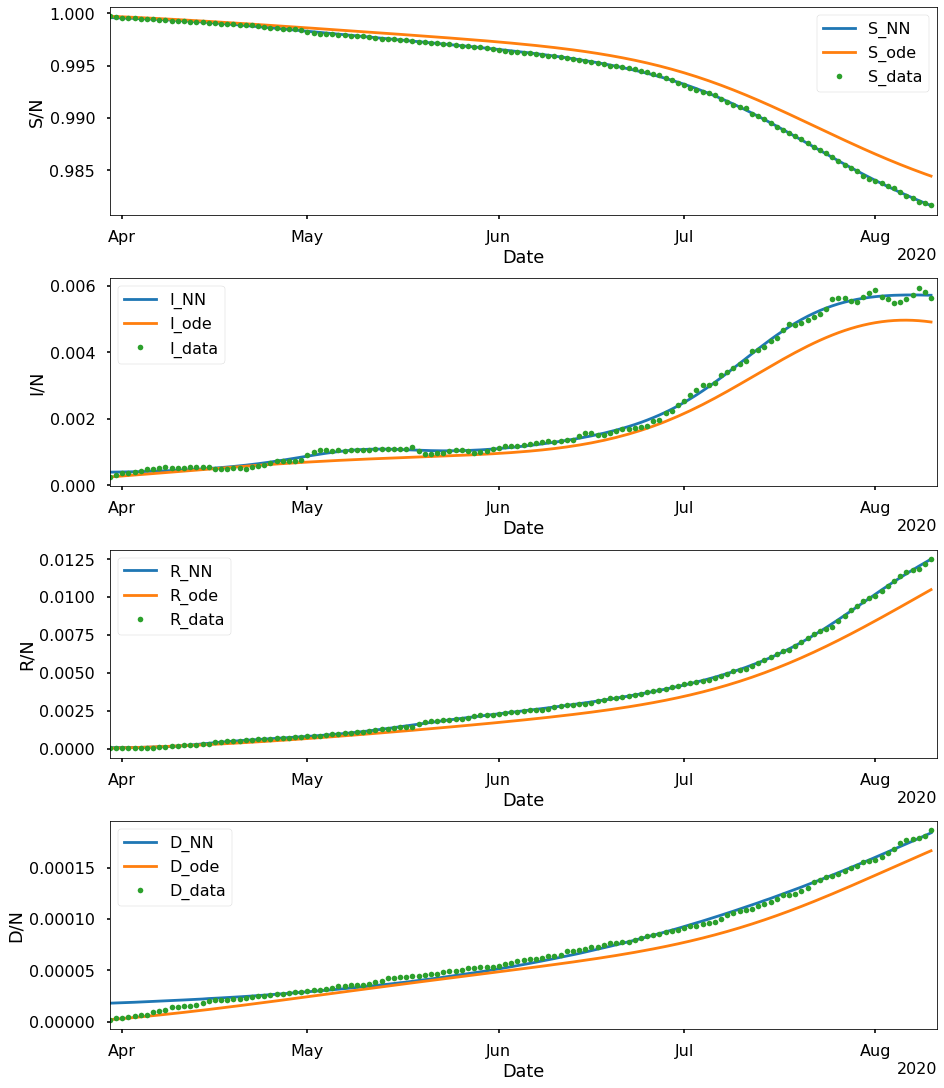

In [26]:
fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(13, 15))
y = np.array([s,i,r,d])
y1 = np.array([SS/N0,II/N0,RC/N0,DC/N0])
y2 = np.array([rk1_s,rk1_i,rk1_r,rk1_d])
y_label = ["S/N","I/N","R/N","D/N"]
legend = [("S_NN","S_ode","S_data"),("I_NN","I_ode","I_data"),("R_NN","R_ode","R_data"),("D_NN","D_ode","D_data")]
for nn, ax in enumerate(axs):
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.plot(dates, y[nn])
    ax.plot(dates, y2[nn])
    ax.plot(dates, y1[nn],'.')
    ax.set_xlabel("Date")
    ax.set_ylabel(y_label[nn])
    ax.set_xlim(lims)
    ax.legend(legend[nn])
plt.show()

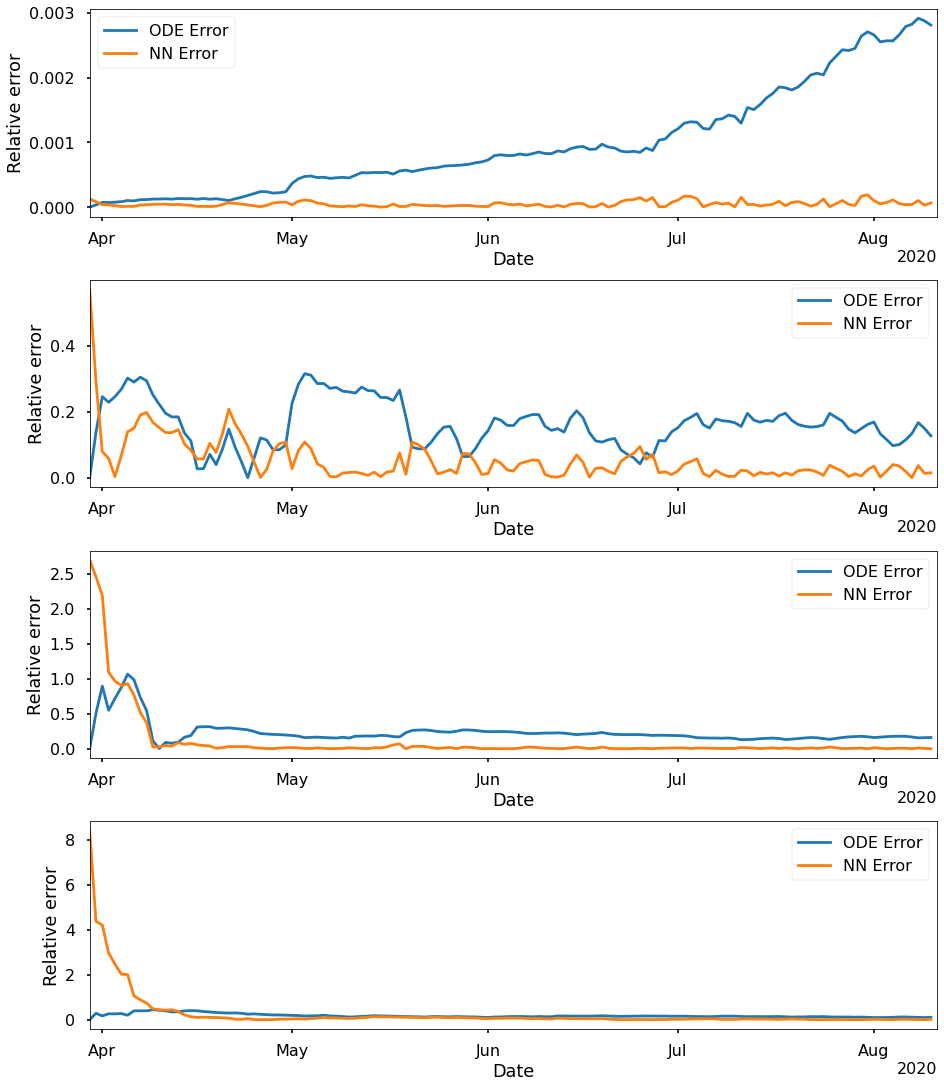

In [27]:
fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(13, 15))
ode_err = np.array([np.abs(np.array(rk1_s).reshape(length,1) - SS/N0)/(SS/N0),np.abs(np.array(rk1_i).reshape(length,1) - II/N0)/(II/N0),np.abs(np.array(rk1_r).reshape(length,1) - RC/N0)/(RC/N0),np.abs(np.array(rk1_d).reshape(length,1) - DC/N0)/(DC/N0)])
nn_err = np.array([np.abs(s - SS/N0)/(SS/N0),np.abs(i - II/N0)/(II/N0),np.abs(r - RC/N0)/(RC/N0),np.abs(d - DC/N0)/(DC/N0)])
for nn, ax in enumerate(axs):
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.plot(dates, ode_err[nn])
    ax.plot(dates, nn_err[nn])
    ax.set_xlabel("Date")
    ax.set_ylabel('Relative error')
    ax.set_xlim(lims)
    ax.legend(("ODE Error","NN Error"))
plt.show()

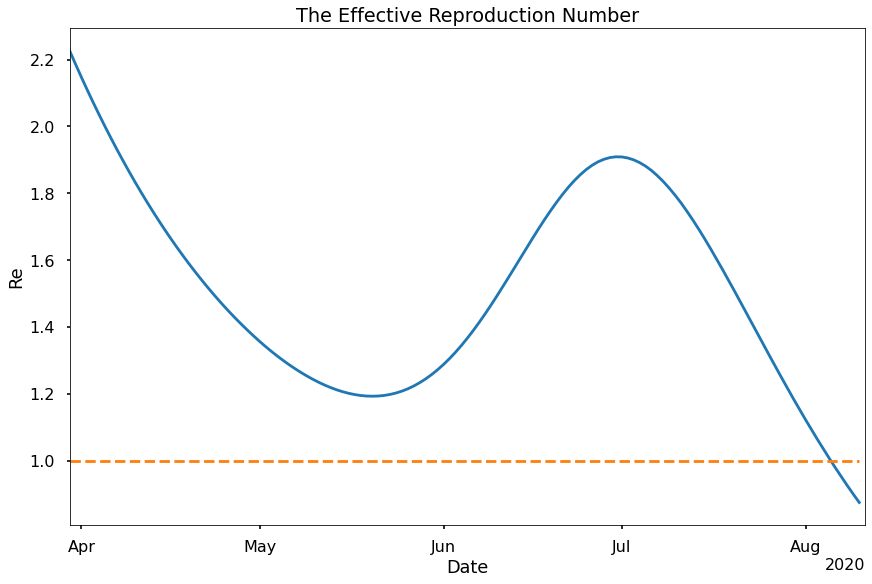

In [28]:
R0 = (SS/N0)*beta/(mu+gamma)
date_begin1 = dt.datetime(2020,3,30)
date_end1 = dt.datetime(2020,8,11)
delta1 = dt.timedelta(days=1)
dates1 = mpl.dates.drange(date_begin1, date_end1, delta1)
fig, axs = plt.subplots(constrained_layout=True, figsize=(12, 8))
lims1 = (np.datetime64('2020-03-30'), np.datetime64('2020-08-11'))
ones = [1]*(R0.shape[0])
ones = np.array(ones).reshape(len(ones),1)
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)
axs.plot(dates1, R0)
axs.plot(dates1,ones,'--')
axs.set_xlabel("Date")
axs.set_ylabel("Re")
axs.set_xlim(lims1)
axs.set_title("The Effective Reproduction Number")
plt.show()

In [5]:
#SIRD model
np.random.seed(1234)
tf.set_random_seed(1234)
#tf.compat.v1.disable_eager_execution()
class SIRD1:
    def __init__(self, I, R, S,D, T,N0, layers):
        self.t = T
        self.I = I
        self.R = R
        self.S = S
        self.D = D
        self.layers = layers
        self.N = N0
        self.lb = T.min()
        self.ub = T.max()
        # Initialize NN
        self.weights1, self.biases1 = self.initialize_NN(self.layers)
        self.weights2, self.biases2 = self.initialize_NN(self.layers)
        self.weights3, self.biases3 = self.initialize_NN(self.layers)
        self.weights4, self.biases4 = self.initialize_NN(self.layers)
        self.weights5, self.biases5 = self.initialize_NN(self.layers)
        self.weights6, self.biases6 = self.initialize_NN(self.layers)
        self.weights7, self.biases7 = self.initialize_NN(self.layers)
        #tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.I_tf = tf.placeholder(tf.float32, shape=[None, self.I.shape[1]])
        self.R_tf = tf.placeholder(tf.float32, shape=[None, self.R.shape[1]])
        self.S_tf = tf.placeholder(tf.float32, shape=[None, self.S.shape[1]])
        self.D_tf = tf.placeholder(tf.float32, shape=[None, self.D.shape[1]])
        self.S_pred, self.I_pred, self.R_pred,self.D_pred,self.beta_pred,self.gamma_pred,self.mu_pred,self.E1_pred, self.E2_pred, self.E3_pred, self.E4_pred,self.E5_pred = self.physic(
            self.t_tf)
        self.GE_loss = tf.reduce_mean(tf.abs(self.E1_pred)) + tf.reduce_mean(tf.abs(self.E2_pred)) +\
                        tf.reduce_mean(tf.abs(self.E3_pred)) + tf.reduce_mean(tf.abs(self.E4_pred)) + tf.reduce_mean(tf.abs(self.E5_pred))
        self.S_loss = 0
        self.I_loss = 0
        self.R_loss = 0
        self.D_loss = 0
        iter = 0
        for i in range(len(T)):
            if T[i]%1 == 0:
                self.S_loss += tf.abs(self.S_tf[iter] - self.S_pred[i])
                self.I_loss += tf.abs(self.I_tf[iter] - self.I_pred[i])
                self.R_loss += tf.abs(self.R_tf[iter] - self.R_pred[i])
                self.D_loss += tf.abs(self.D_tf[iter] - self.D_pred[i])
                iter += 1
        self.OB_loss = (self.I_loss + self.R_loss + self.S_loss + self.D_loss)/iter
        self.loss = self.OB_loss + self.GE_loss
        '''
        self.loss = tf.reduce_mean(tf.abs(self.I_tf - self.I_pred)) + tf.reduce_mean(tf.abs(self.R_pred - self.R_tf)) +\
                    tf.reduce_mean(tf.abs(self.S_tf - self.S_pred)) +\
                    tf.reduce_mean(tf.abs(self.E1_pred))+ tf.reduce_mean(tf.abs(self.E2_pred)) +\
                    tf.reduce_mean(tf.abs(self.E3_pred)) + tf.reduce_mean(tf.abs(self.E4_pred)) 
        '''
        
        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        # Optimizers
        '''
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})    
        '''                                                                                          
        init = tf.global_variables_initializer()
        self.sess.run(init)
         
        
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers)
        
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def forward_soft(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.softplus(tf.add(tf.matmul(H, W), b))
        return Y

    def forward_sig(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.sigmoid(tf.add(tf.matmul(H, W), b))
        return Y

    def physic(self, t):
        beta = self.forward_sig(t,self.weights5,self.biases5)
        gamma = self.forward_sig(t,self.weights6,self.biases6)
        mu = self.forward_sig(t,self.weights7,self.biases7)
        S = self.forward_sig(t, self.weights1, self.biases1)
        I = self.forward_sig(t, self.weights2, self.biases2)
        R = self.forward_sig(t, self.weights3, self.biases3)
        D = self.forward_sig(t, self.weights4, self.biases4)
        E1 = tf.gradients(S, t)[0] + beta*S*I
        E2 = tf.gradients(I, t)[0] - beta*S*I + (mu+gamma)*I
        E3 = tf.gradients(R, t)[0] - gamma*I
        E4 = tf.gradients(D, t)[0] - mu*I
        E5 = 1 - (S+I+R+D)
        return S,I,R,D,beta,gamma,mu,E1,E2,E3,E4,E5

    def callback(self, loss):
        print('Loss: %.3e' % (loss))
    def train(self, nIter): 

        tf_dict = {self.t_tf: self.t, self.I_tf: self.I,self.R_tf: self.R,self.S_tf: self.S,self.D_tf: self.D}
                   
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 500 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value,elapsed))
                start_time = time.time()      
    def predict(self, t_star):
        tf_dict = {self.t_tf: t_star}
        S = self.sess.run(self.S_pred, tf_dict)
        I = self.sess.run(self.I_pred, tf_dict)
        R = self.sess.run(self.R_pred, tf_dict)
        D = self.sess.run(self.D_pred, tf_dict)
        beta = self.sess.run(self.beta_pred,tf_dict)
        gamma = self.sess.run(self.gamma_pred,tf_dict)
        mu = self.sess.run(self.mu_pred,tf_dict)
        #gamma = self.sess.run(self.gamma_pred,tf_dict)
        return S,I,R,D,beta,gamma,mu

In [6]:
T = np.arange(0,length - 0.05,0.05)#here I used Nt with 0.1 stepsize
T = T.reshape(len(T),1)
layers = [1,32,32,32,32,1]
model1 = SIRD1(II/N0,RC/N0,SS/N0,DC/N0,T,1,layers)
model1.train(100000)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

It: 0, Loss: 3.935e+00, Time: 6.52
It: 500, Loss: 1.861e-03, Time: 21.81
It: 1000, Loss: 1.573e-03, Time: 21.26
It: 1500, Loss: 1.322e-03, Time: 21.02
It: 2000, Loss: 1.128e-03, Time: 21.03
It: 2500, Loss: 1.398e-03, Time: 20.95
It: 3000, Loss: 1.046e-03, Time: 20.86
It: 3500, Loss: 1.049e-03, Time: 20.81
It: 4000, Loss: 1.008e-03, Time: 20.86
It: 4500, Loss: 9.857e-04, Time: 20.93
It: 5000, Loss: 9.248e-04, Time: 20.72
It: 5500, Loss: 8.198e-04, Time: 20.54
It: 6000, Loss: 8.432e-04, Time: 20.60
It: 6500, Loss: 8.110e-04, Time: 21.11
It: 7000, Loss: 7.698e-04, Time: 20.81
It: 7500, Loss: 7.054e-04, Time: 20.77
It: 8000, Loss: 6.527e-04, Time: 20.87
It: 8500, Loss: 6.413e-04, Time: 20.62
It: 9000, Loss: 6.428e-04, Time: 20.73
It: 9500, Loss: 6.823e-04, Time: 20.84
It: 10000, Loss: 6.089e-04, Time: 20.62
It: 10500, Loss: 6.808e-04, Time: 20.67
It: 11000, Loss: 6.257e-04, Time: 20.60
It: 11500, Lo

[9.99731085e-01 2.51026393e-04 1.59824047e-05 1.90615836e-06]
[1.01482846]


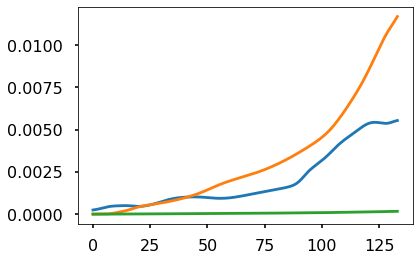

In [7]:
T = np.arange(0,length).reshape(length,1)
s,i,r,d,beta,gamma,mu= model1.predict(T)
def sird_model(z,t,beta_value,gamma,mu):
    s = z[0,]
    i = z[1,]
    r = z[2,]
    d = z[3,]
    dsdt = -beta_value*i*s
    didt = beta_value*i*s - (mu+gamma)*i
    drdt = gamma*i
    dddt = mu*i
    dzdt = [dsdt,didt,drdt,dddt]
    dzdt = np.array(dzdt)
    return dzdt
t = np.arange(0,T.shape[0])
# initial condition
z10 = np.array([SS[0,0]/N0,II[0,0]/N0,RC[0,0]/N0,DC[0,0]/N0])
print(z10)
rk1_s = [0.0]*T.shape[0]
rk1_i = [0.0]*T.shape[0]
rk1_r = [0.0]*T.shape[0]
rk1_d = [0.0]*T.shape[0]
rk1_s[0] = z10[0]
rk1_i[0] = z10[1]
rk1_r[0] = z10[2]
rk1_d[0] = z10[3]
# solve ODE
for l in range(1,T.shape[0]):
  # span for next time step
    tspan = [t[l-1],t[l]]
    # solve for next step
    z1 = odeint(sird_model,z10,tspan,args=(beta[l-1,0],gamma[l-1,0],mu[l-1,0]))
    # store solution for plotting
    rk1_s[l] = z1[1][0]
    rk1_i[l] = z1[1][1]
    rk1_r[l] = z1[1][2]
    rk1_d[l] = z1[1][3]
    # next initial condition
    z10 = z1[1]
plt.plot(t,rk1_i)
plt.plot(t,rk1_r)
plt.plot(t,rk1_d)
mul = (II[-1]/N0)/rk1_i[-1]
print(mul)

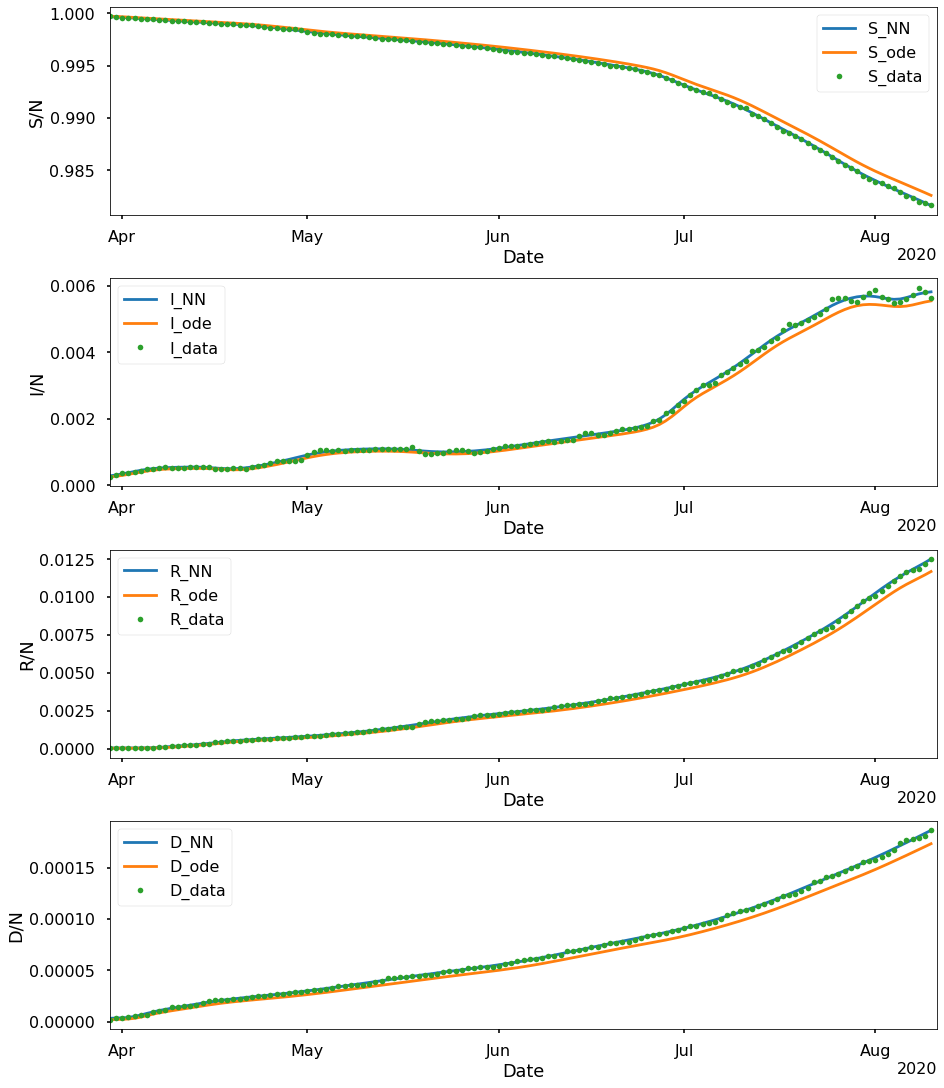

In [8]:
fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(13, 15))
y = np.array([s,i,r,d])
y1 = np.array([SS/N0,II/N0,RC/N0,DC/N0])
y2 = np.array([rk1_s,rk1_i,rk1_r,rk1_d])
y_label = ["S/N","I/N","R/N","D/N"]
legend = [("S_NN","S_ode","S_data"),("I_NN","I_ode","I_data"),("R_NN","R_ode","R_data"),("D_NN","D_ode","D_data")]
for nn, ax in enumerate(axs):
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.plot(dates, y[nn])
    ax.plot(dates, y2[nn])
    ax.plot(dates, y1[nn],'.')
    ax.set_xlabel("Date")
    ax.set_ylabel(y_label[nn])
    ax.set_xlim(lims)
    ax.legend(legend[nn])
plt.show()

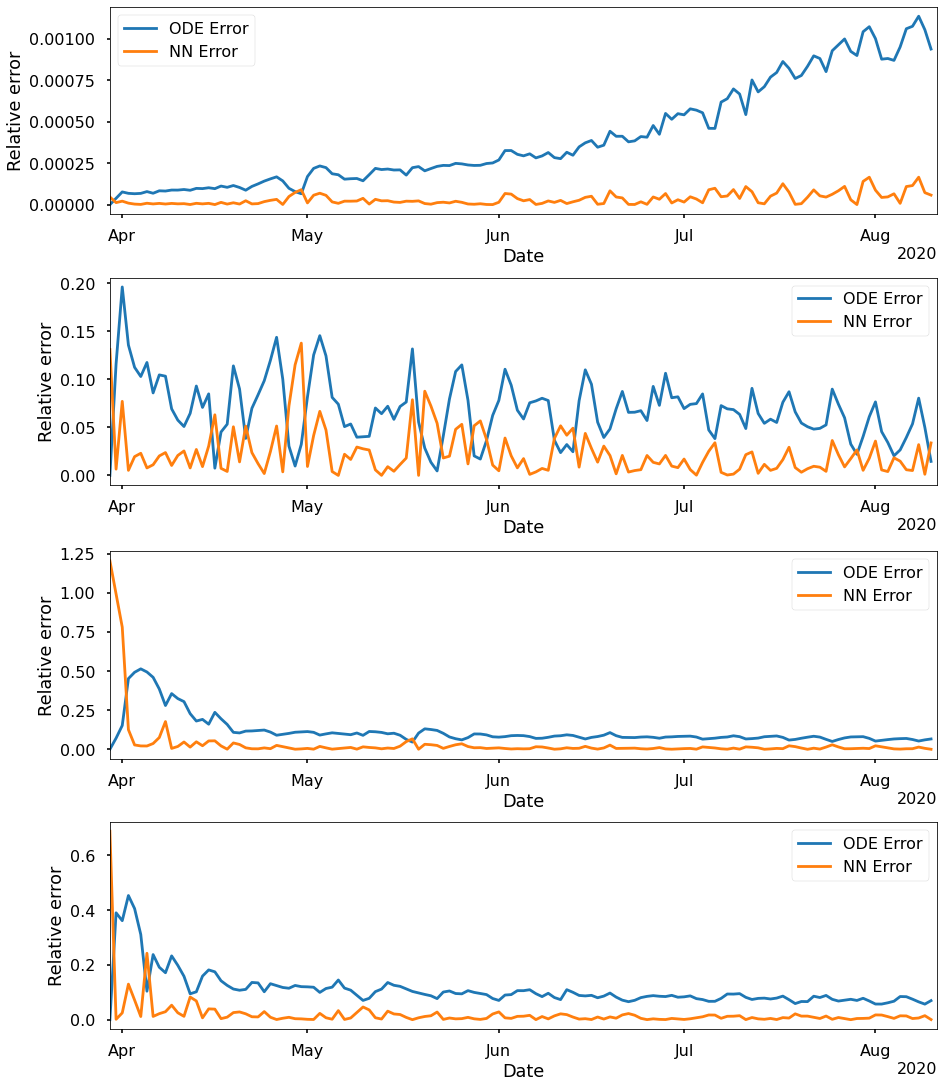

In [9]:
fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize=(13, 15))
ode_err = np.array([np.abs(np.array(rk1_s).reshape(length,1) - SS/N0)/(SS/N0),np.abs(np.array(rk1_i).reshape(length,1) - II/N0)/(II/N0),np.abs(np.array(rk1_r).reshape(length,1) - RC/N0)/(RC/N0),np.abs(np.array(rk1_d).reshape(length,1) - DC/N0)/(DC/N0)])
nn_err = np.array([np.abs(s - SS/N0)/(SS/N0),np.abs(i - II/N0)/(II/N0),np.abs(r - RC/N0)/(RC/N0),np.abs(d - DC/N0)/(DC/N0)])
for nn, ax in enumerate(axs):
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.plot(dates, ode_err[nn])
    ax.plot(dates, nn_err[nn])
    ax.set_xlabel("Date")
    ax.set_ylabel('Relative error')
    ax.set_xlim(lims)
    ax.legend(("ODE Error","NN Error"))
plt.show()

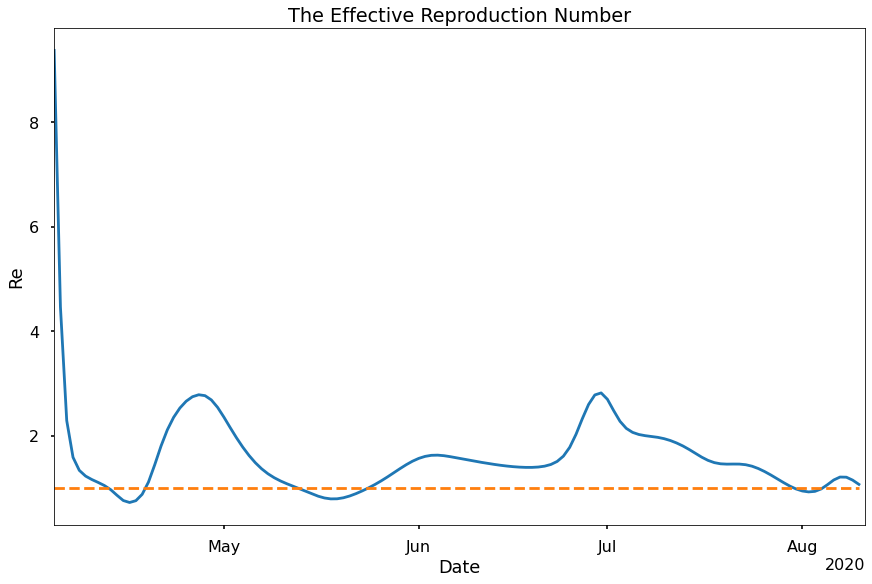

In [11]:
R0 = (SS/N0)*beta/(mu+gamma)
date_begin1 = dt.datetime(2020,4,4)
date_end1 = dt.datetime(2020,8,11)
delta1 = dt.timedelta(days=1)
dates1 = mpl.dates.drange(date_begin1, date_end1, delta1)
fig, axs = plt.subplots(constrained_layout=True, figsize=(12, 8))
lims1 = (np.datetime64('2020-04-04'), np.datetime64('2020-08-11'))
ones = [1]*(R0.shape[0] - 5)
ones = np.array(ones).reshape(len(ones),1)
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)
axs.plot(dates1, R0[5:])
axs.plot(dates1,ones,'--')
axs.set_xlabel("Date")
axs.set_ylabel("Re")
axs.set_xlim(lims1)
axs.set_title("The Effective Reproduction Number")
plt.show()